# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [1]:
%matplotlib inline
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
from astropy.modeling import models, fitting, optimizers, statistic, custom_model
import batman
#from ldtk import (LDPSetCreator,BoxcarFilter)
#from ldtk.filters import kepler
import corner as triangle
import astropy.constants as c
import astropy.units as u

In [2]:
def BATMAN(P,
           Rp,
           t0,
           inc,
           A,
           LD,
           t = None,
           Baseline = 1.0):
                    
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = A                         # semi-major axis (in units of stellar radii)
    params.inc = inc                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    #m = batman.TransitModel(params, t, exp_time=60.0, supersample_factor = 12)   # initializes model
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

In [3]:
def lnprior(LC1,
            theta,
            planet_a):
    
    A1,t1,rp,a,i = theta
        
    i_min = np.arccos(1/a)*180/np.pi

    if (0.0 <= rp <= 1.0) and (2 <= a <= 200) and (i_min <= i <= 90.0):
        
        return 0.0
    
    return -np.inf

In [4]:
def lnprob(theta,
           LC1,
           planet_period,
           LD,
           planet_a,
           plot = False):
        
    # Pull out some model parameters
    A1,t1,rp,a,i = theta   
    
    # First we want a model to perform the lnprob calculation with.
    model1 = A1*BATMAN(planet_period, rp, t1, i, a, LD, t = LC1.time)
        
    # We need to make sure the uniform priors are accounted for:
    ln_prior = lnprior(LC1, theta, planet_a)
    
    # This is a Gaussian likelihood, for independent data points
    
    chisq1 = np.sum((LC1.flux - model1)**2/(LC1.flux_err)**2)
    ln_like1 = (np.sum(1/np.sqrt(2*np.pi*(LC1.flux_err))) - 0.5*chisq1)
    
    return ln_prior+ln_like1

In [5]:
def corner(samples):
        
    labels = ['Rp/R*','a/R*','i (deg)']
    Samples = samples[-3:].T
    
    np.random.seed(41)
    figure = triangle.corner(Samples,labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
    plt.savefig('TOI_{:.0f}_Corner.pdf'.format(toi))

In [6]:
def light_curve(lc,
                best_parameters,
                sampler,
                static_params,
                nsteps,
                tic_id,
                obs='first'):
    
    ########################
    # Read in the parameters
    ########################
    
    planet_radius, planet_period, planet_a, planet_i, toi = static_params
    hires_times = np.linspace(-0.5,0.5,100000)
    C1_best, rp_best, t_0_best, a_best, i_best = best_parameters
    burnin = int(0.25*nsteps)
    
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    A1_sam,t01_sam,Rp,A,Inc = samples
    
    if obs == 'first':
        C1 = A1_sam
        t0 = t01_sam
        
    ########################################################################
    # Calculate the model with the best-fit MCMC params, calculate residuals
    ########################################################################
    
    model_to_plot = BATMAN(planet_period, rp_best, t_0_best, i_best, a_best, LD, t = hires_times)
    best_model = C1_best*BATMAN(planet_period, rp_best, t_0_best,
                                i_best, a_best, LD, t = lc.time)
    residual = (lc.flux-best_model)/lc.flux_err
    
    #########################
    # Plot the best-fit model
    #########################
            
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title('Folded TESS Light Curve for TOI {}'.format(toi),fontsize=20)
    a0.errorbar((lc.time-t_0_best)*24,lc.flux/(C1_best),
                yerr=lc.flux_err/C1_best,
                fmt='o',alpha=0.5,color='royalblue',markersize='5')
    a0.plot((hires_times-t_0_best)*24,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Normalized Flux',fontsize=18)
    a0.set_xlim(-2.5,2.5) #hrs from mid transit
    a0.set_ylim(0.985,1.01)
    a0.minorticks_on()
    a0.legend(loc='lower right')
    a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    #########################################
    # Plot 200 random models from the samples
    #########################################
    
    for j in range(0,200,1):
        i = np.random.randint(low=0,high=(nsteps-burnin)*100)
        sigma_model = BATMAN(P = planet_period, Rp = Rp[i], t0 = t0[i],
                             inc = Inc[i], A = A[i], LD = LD, t = hires_times)
        a0.plot((hires_times-t_0_best)*24,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000,label='Random Samples')
        
    ####################
    # Plot the residuals
    ####################

    a1.scatter((lc.time-t_0_best)*24,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.minorticks_on()
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.set_xlabel('Time from Mid-Transit (hr)')
    a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
        
    plt.xlabel('Hr from mid-transit',fontsize=16)
    plt.savefig('TOI_{:.0f}_TESS_modeled'.format(toi)+obs+'.pdf')

In [7]:
params = pandas.read_csv('TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']

In [8]:
index = int(102)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'LCO 1-m'
print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 231702397
TOI 122.01


In [9]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
epoch = Epoch
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun
star_mass = params['M_s'][index]

expected_t0_1 = 0
LD = [0.24194757,0.36610905]

In [10]:
data_all = lcf = lk.search_lightcurvefile('TIC {}'.format(int(tic_id))).download_all()
LC_all = lcf[0].PDCSAP_FLUX.remove_outliers(sigma=10)#.fold(planet_period,epoch)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


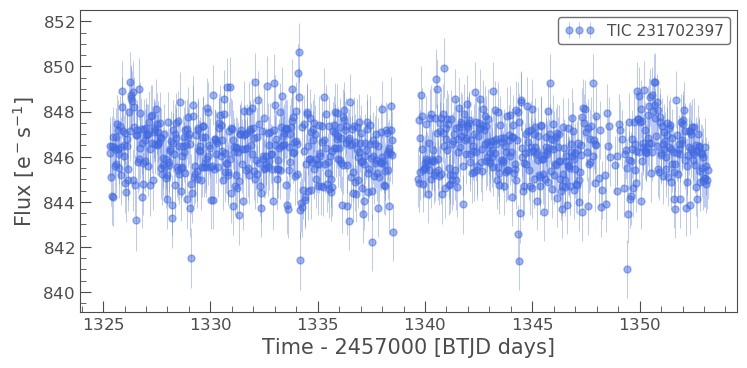

In [17]:
LC_all.bin(binsize=20).errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
#plt.xlim(-2,2)

(-2, 2)

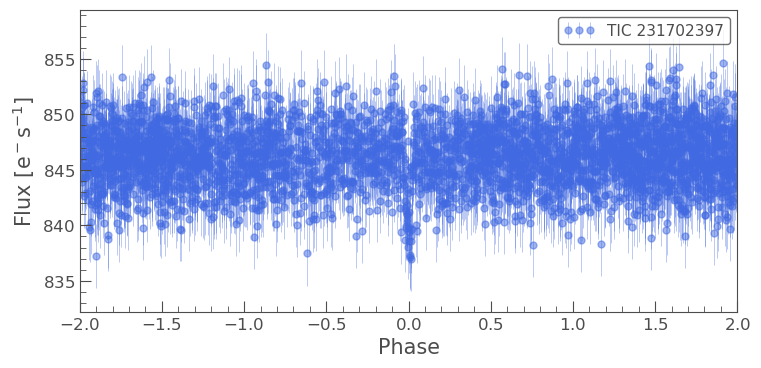

In [13]:
LC1 = LC_all.bin(binsize=4)

A1 = np.median(LC1.flux)
LC1.time = LC1.time*planet_period #now the  time array is in days

LC1.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
plt.xlim(-2,2)

In [14]:
# intialize some walkers
ndim, nwalkers, nsteps = 5, 100, 50000
burnin = int(0.2*nsteps)

# these are initial parameters
A1_init = np.random.uniform(A1-0.0005, A1+0.0005, nwalkers)

t01_init = np.random.uniform(-0.00005,0.00005, nwalkers)

Rp_init = np.random.uniform(planet_radius-0.001, planet_radius+0.001, nwalkers)
a_init = np.random.uniform(planet_a-0.0005, planet_a+0.0005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

p0 = np.transpose([A1_init,
                   t01_init,
                   Rp_init, a_init, i_init])

theta = [A1,
         expected_t0_1,
         planet_radius,planet_a,planet_i]

In [15]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args = (LC1,
                                        planet_period,LD,
                                        planet_a))
result = sampler.run_mcmc(p0, nsteps)

C:\Users\wwaal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arccos
  import sys


In [16]:
static_params = planet_radius, planet_period, planet_a, planet_i, toi
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
A1_sam,t01_sam,Rp_sam,A_sam,Inc_sam = samples

sig1_A1 = np.percentile(A1_sam, [16., 50., 84.])
sig1_t01 = np.percentile(t01_sam, [16., 50., 84.])

sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

np.save('TOI122_TESS_samples.dat',samples)

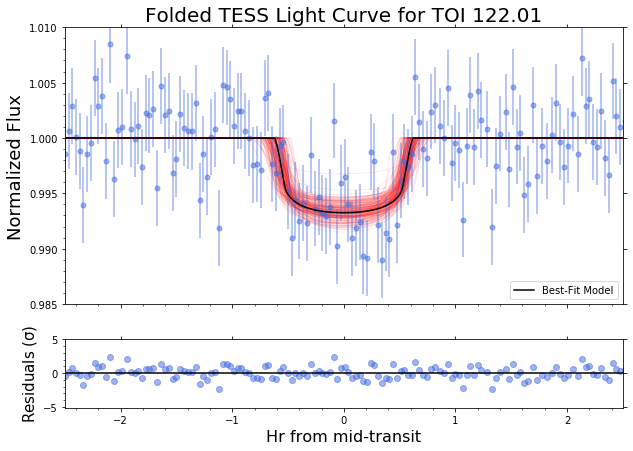

In [17]:
best_parameters = [sig1_A1[1],sig1_Rp[1],sig1_t01[1],sig1_A[1],sig1_Inc[1]]
#best_parameters = [sig1_A1[1],0.06,expected_t0_1,36,90]
light_curve(LC1,best_parameters,sampler,static_params,nsteps,tic_id,obs='first')

In [18]:
print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(sig1_t01[1]),
      '+ {:.6f}'.format(sig1_t01[2]-sig1_t01[1]),
      '- {:.6f}'.format(sig1_t01[1]-sig1_t01[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_1))

Rp/R* = 0.0772 + 0.0053 - 0.0047
Rp (R_E) = 2.817 + 0.193 - 0.170
a/R* = 30.509 + 4.061 - 7.336
Inclination (Deg) = 89.173 + 0.588 - 0.991
Impact parameter (b) = 0.440
Mid-Transit Time = -0.001003 + 0.001340 - 0.001436
Anticipated mid-transit time = 0.000000


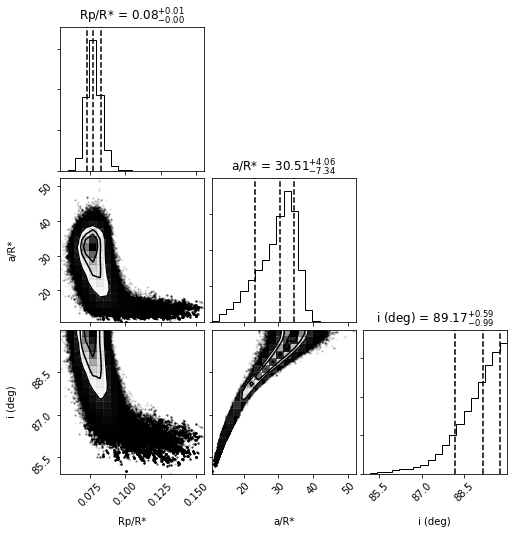

In [19]:
corner(samples)